# TQQQ Demo

In [18]:
import pandas as pd

## Simulating Leveraged Adjusted Close Prices

The code loads and processes simulated leveraged adjusted close prices for a given equity. Here's a breakdown:
- The function `simulate_data.process_leveraged_data()` downloads historical price data for a specified ticker (e.g., "QQQ") and uses a leverage scalar (e.g., 3x) to determine the multiplier for leveraged returns.
- The function calculates daily percentage returns (`Daily Return`) from the adjusted close prices.
- Leveraged returns are simulated by multiplying the daily returns by the specified leverage scalar.
- These leveraged returns are then compounded to simulate the cumulative leveraged price (`Simulated Leveraged Price`).


In [19]:
# Load in the desired ticker
import simulate_data
data = simulate_data.process_leveraged_data('QQQ', 3)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Daily Return,Leveraged Return,Simulated Leveraged Price
0,1999-03-10,51.12500,51.156250,50.28125,51.0625,43.417282,5232000,NaN,0.000000,43.417282
1,1999-03-11,51.43750,51.734375,50.31250,51.3125,43.629868,9688600,0.004896,0.014689,44.055038
2,1999-03-12,51.12500,51.156250,49.65625,50.0625,42.567009,8743600,-0.024361,-0.073082,40.835390
3,1999-03-15,50.43750,51.562500,49.90625,51.5000,43.789265,6369000,0.028714,0.086141,44.352994
4,1999-03-16,51.71875,52.156250,51.15625,51.9375,44.161263,4905800,0.008495,0.025486,45.483354


C:\Users\Sterling Hayden\AppData\Local\Temp\ipykernel_10576\2764234336.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])


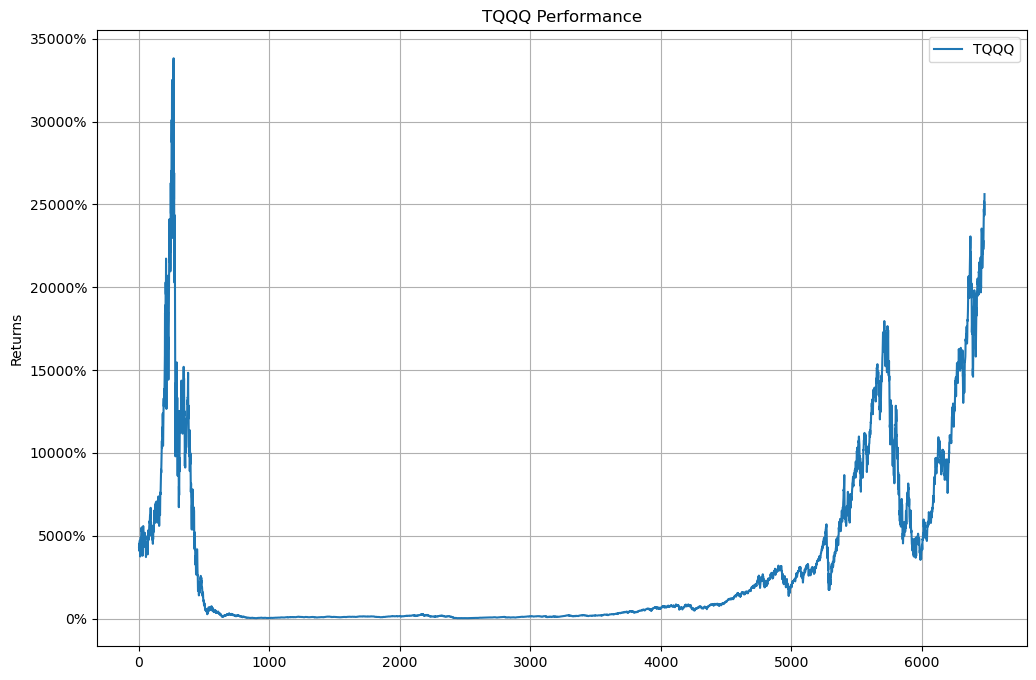

In [58]:
import matplotlib.pyplot as plt

# Graphing the Cumulative returns of the ETF's and splits in question
plt.figure(figsize=(12, 8))
plt.plot(data['Simulated Leveraged Price'], label='TQQQ')
plt.legend()
plt.title('TQQQ Performance')
plt.ylabel('Returns')
plt.gca().set_yticklabels([f'{x:.0%}' for x in plt.gca().get_yticks()])
plt.grid(True)
plt.show()

## Identifying Indices of All-Time Highs

This code identifies the indices where the adjusted close price and the simulated leveraged price reach new all-time highs to be used later in analysis.

In [ ]:
# Grab Indices where the 'Adj Close' is the new all time high
ath_indices_baseline = []
current_ath = -9999
for idx, value in data['Adj Close'].items():
    if value > current_ath:
        current_ath = value
        ath_indices_baseline.append(idx)

# Grab Indices where the 'Simulated Leveraged Price' is the new all time high
ath_indices_leveraged  = []
current_ath = -9999
for idx, value in data['Simulated Leveraged Price'].items():
    if value > current_ath:
        current_ath = value
        ath_indices_leveraged .append(idx)

# Add a flag to identify when an ATH occurs
data['ATH_baseline_flag'] = data.index.isin(ath_indices_baseline).astype(int)
data['ATH_leveraged_flag'] = data.index.isin(ath_indices_leveraged).astype(int)

In [53]:
print(len(ath_indices_baseline))
print(len(ath_indices_leveraged))

408
58


## Calculating Returns 

Calculate returns for investments made at all-time highs given a holding period of Z days.
- 3 Months is 91 days
- 6 Months is 182 days
- 12 Months is 365 days
- 24 Months is 730 days

### Calculating Retruns of TQQQ

In [50]:
def calculate_ath_returns_all_periods(data, ath_indices):
    holding_periods = {
        'Return_3M': 91,  # 3 months
        'Return_6M': 182, # 6 months
        'Return_12M': 365, # 12 months
        'Return_24M': 730  # 24 months
    }
    
    results = []
    for idx in ath_indices:
        row = {'ATH_Index': idx, 'Date': data.loc[idx, 'Date']}
        for period_name, holding_period in holding_periods.items():
            if idx + holding_period < len(data):
                entry_price = data['Adj Close'].iloc[idx]
                exit_price = data['Adj Close'].iloc[idx + holding_period]
                return_pct = (exit_price - entry_price) / entry_price
                row[period_name] = return_pct
            else:
                row[period_name] = None  # Handle cases where holding period exceeds data length

        results.append(row)
    return pd.DataFrame(results)

# usage
returns_df = calculate_ath_returns_all_periods(data, ath_indices_leveraged)
print(returns_df.iloc[:,2:].describe())


       Return_3M  Return_6M  Return_12M  Return_24M
count  58.000000  58.000000   58.000000   58.000000
mean    0.195079   0.270534   -0.171983   -0.614358
std     0.261241   0.363669    0.476497    0.154785
min    -0.234607  -0.416269   -0.712102   -0.789639
25%     0.006912   0.129513   -0.465858   -0.704008
50%     0.128789   0.253782   -0.371219   -0.684782
75%     0.429783   0.506673   -0.029459   -0.542476
max     0.741445   0.987342    0.875153   -0.288911


In [ ]:
def calculate_non_ath_returns(data, ath_indices, holding_period):
    returns = []
    dates = []
    
    # Loop through all indices that are not in `ath_indices`
    for idx in data.index:
        if idx not in ath_indices:  # Check if the index is not in `ath_indices`
            if idx + holding_period < len(data):  # Ensure holding period is valid
                entry_price = data['Adj Close'].iloc[idx]
                exit_price = data['Adj Close'].iloc[idx + holding_period]
                return_pct = (exit_price - entry_price) / entry_price
                returns.append(return_pct)
                dates.append(data.loc[idx, 'Date'])
    
    return pd.DataFrame({'Date': dates, 'Return': returns})

# Example usage
non_ath_returns_df = calculate_non_ath_returns(data, ath_indices_leveraged, holding_period=91)  # 3-month holding period

# Inspect results
print(returns_df.Return.describe())


count    400.000000
mean       0.068344
std        0.132784
min       -0.252694
25%        0.019119
50%        0.054365
75%        0.110963
max        0.741445
Name: Return, dtype: float64
